In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, Dropout,
    MultiHeadAttention, GlobalAveragePooling1D,
    Masking
)
from tensorflow.keras.utils import to_categorical
from keras.utils import custom_object_scope
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

In [2]:
df= pd.read_csv('D:\year 3\Semester 2\Data Science\Sales-Customer-Behavior-Analysis\Preprocessing\Preprocessed dataset\Preprocessed Time Series Final.csv')

In [3]:
df.head()

product_id          category_id     price    user_id  \
0    44600062  2103807459595387724 -0.710172  541312140   
1     1004545  2053013555631882655  0.768298  537918940   
2    29800030  2053013559842964121 -0.336330  555306597   
3    16800186  2053013558316237377  0.159003  555446365   
4     1005020  2053013555631882655 -0.523655  550859983   

                           user_session  category_code_0  category_code_1  \
0  72d76fde-8bb3-4e00-8c23-a032dfed738c                0                0   
1  406c46ed-90a4-4787-a43b-59a410c1a5fb                0                0   
2  3a374230-2ac7-429d-8fe0-92ad8fdc6b28                0                0   
3  7f0062d8-ead0-4e0a-96f6-43a0b79a2fc4                0                0   
4  4718c88d-1892-4a5f-931a-f61ad7a20459                0                0   

   category_code_2  category_code_3  category_code_4  ...  brand_3  brand_4  \
0                0                0                0  ...        0        0   
1                0                0                0  ...        0        0   
2                0                0                0  ...        0        0   
3                0                0                0  ...        0        0   
4                0                0                0  ...        0        0   

   brand_5  brand_6  brand_7  brand_8  brand_9  brand_10  brand_11  event_type  
0        0        0        0        0        0         0         1        view  
1        0        0        0        0        0         1         0        view  
2        0        0        0        0        0         1         1        view  
3        0        0        0        0        0         1         1        view  
4        0        0        0        0        1         0         0        view  

[5 rows x 25 columns]

In [4]:
features = ['price'] + [f'category_code_{i}' for i in range(5)] + [f'brand_{i}' for i in range(12)]

In [5]:
 #Step 2: Prepare X and y
X = df[features].values  # shape (num_samples, num_features)
y = df['event_type'].values  # labels (strings)


In [6]:
# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
y_onehot = to_categorical(y_encoded, num_classes=num_classes)

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

In [8]:
# Reshape input for Transformer: (samples, timesteps, features)
# Here seq_length = 1 for simplicity, but ideally >1 for Transformer
seq_length = 1
num_features = len(features)
X_train = X_train.reshape((X_train.shape[0], seq_length, num_features))
X_test = X_test.reshape((X_test.shape[0], seq_length, num_features))

In [9]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Residual connection

    # Feed-forward network
    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res  # Residual connection

In [10]:
# Build Transformer model
inputs = Input(shape=(seq_length, num_features))
x = Masking(mask_value=0.)(inputs)

x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

In [11]:
model = Model(inputs, outputs)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


C:\Users\Nouran\AppData\Roaming\Python\Python310\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 129s 6ms/step - accuracy: 0.9595 - loss: 0.1924 - val_accuracy: 0.9607 - val_loss: 0.1838
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 130s 7ms/step - accuracy: 0.9609 - loss: 0.1835 - val_accuracy: 0.9607 - val_loss: 0.1826
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 110s 6ms/step - accuracy: 0.9600 - loss: 0.1859 - val_accuracy: 0.9607 - val_loss: 0.1824
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 124s 6ms/step - accuracy: 0.9608 - loss: 0.1821 - val_accuracy: 0.9607 - val_loss: 0.1823
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 116s 6ms/step - accuracy: 0.9605 - loss: 0.1827 - val_accuracy: 0.9607 - val_loss: 0.1821
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 132s 7ms/step - accuracy: 0.9604 - loss: 0.1827 - val_accuracy: 0.9607 - val_loss: 0.1823
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.9607 - loss: 0.1816 - val_accuracy: 0.9607 - val_loss: 0.1817
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step - accuracy: 0.9

In [14]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9605 - loss: 0.1825
Test Accuracy: 0.9606


   1/6250 ━━━━━━━━━━━━━━━━━━━━ 23:29 225ms/step

C:\Users\Nouran\AppData\Roaming\Python\Python310\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


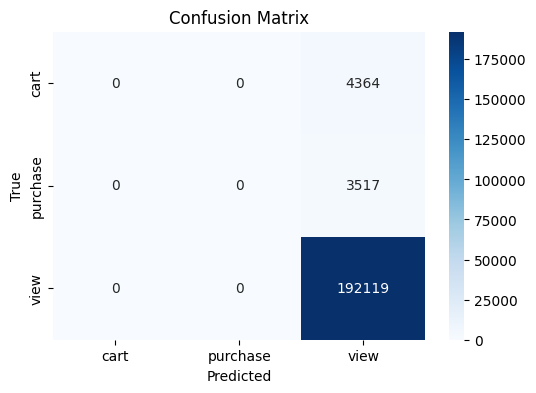

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Get predicted classes for test set
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
from tensorflow.keras.models import load_model

# Save the model
model.save('transformer_model.h5')

